# А/В-тестирование новой рекомендательной системы

**Задача**: проверить результаты А/В-тестирования изменений, связанных с внедрением улучшенной рекомендательной системы.

**План**:

1. Загрузить данные.
2. Изучить основную информацию.
3. Предобработать:
    - изменить типы данных;
    - обработать пропуски;
    - удалить дубликаты;
4. Отфильтровать данные:
    - по региону;
    - по датам;
    - по названию теста.
5. Исследовать данные при помощи визуализации.
6. Подготовить к проверке гипотез:
    - убедиться в корректном разделении групп.
7. Проверить результаты А/В-теста при помощи статистических методов.
8. Написать вывод.

In [2]:
# импортируем все необходимые для работы библиотеки
import pandas as pd # для работы с данными
import numpy as np # для работы с числами
import seaborn as sns # для визуализации
import matplotlib.pyplot as plt # для настройки визуализации
from statsmodels.stats.proportion import proportions_ztest # для теста пропорций
%matplotlib inline
%config InlineBackend.figure_format='retina' # повышение четкости графиков
plt.style.use('seaborn-darkgrid') # задаём стиль графиков

/opt/conda/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Изучаем данные

In [3]:
marketing_events = pd.read_csv('ab_project_marketing_events.csv')
new_users = pd.read_csv('final_ab_new_users.csv')
events = pd.read_csv('final_ab_events.csv')
participants = pd.read_csv('final_ab_participants.csv')

Напишем функцию, которая будет возвращать результаты методов `info` и `describe`, первые 5 строк таблицы и информацию о дубликатах для каждой из 4 таблиц.

In [4]:
def info(dataframes):
    '''
    Для каждой таблицы возвращает результаты методов info() и describe(), первые 5 строк и информацию о дубликатах.
    
    Параметры:
    dataframes (list) — список датафреймов, информацию о которых нужно вывести.
    '''
    for df in dataframes:
        display(df.info())
        display(df.head())
        display(df.describe(include='all', datetime_is_numeric=True))
        print('Duplicates:', df.duplicated().sum())
        print(40*'-'+'\n')

Выведем информацию о датасетах.

In [5]:
datasets = [marketing_events, new_users, events, participants]

In [6]:
info(datasets)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   name       14 non-null     object
 1   regions    14 non-null     object
 2   start_dt   14 non-null     object
 3   finish_dt  14 non-null     object
dtypes: object(4)
memory usage: 576.0+ bytes


None

,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03
1,St. Valentine's Day Giveaway,"EU, CIS, APAC, N.America",2020-02-14,2020-02-16
2,St. Patric's Day Promo,"EU, N.America",2020-03-17,2020-03-19
3,Easter Promo,"EU, CIS, APAC, N.America",2020-04-12,2020-04-19
4,4th of July Promo,N.America,2020-07-04,2020-07-11


,name,regions,start_dt,finish_dt
count,14,14,14,14
unique,14,6,14,14
top,Christmas&New Year Promo,APAC,2020-12-25,2021-01-03
freq,1,4,1,1


Duplicates: 0
----------------------------------------

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61733 entries, 0 to 61732
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     61733 non-null  object
 1   first_date  61733 non-null  object
 2   region      61733 non-null  object
 3   device      61733 non-null  object
dtypes: object(4)
memory usage: 1.9+ MB


None

,user_id,first_date,region,device
0,D72A72121175D8BE,2020-12-07,EU,PC
1,F1C668619DFE6E65,2020-12-07,N.America,Android
2,2E1BF1D4C37EA01F,2020-12-07,EU,PC
3,50734A22C0C63768,2020-12-07,EU,iPhone
4,E1BDDCE0DAFA2679,2020-12-07,N.America,iPhone


,user_id,first_date,region,device
count,61733,61733,61733,61733
unique,61733,17,4,4
top,D72A72121175D8BE,2020-12-21,EU,Android
freq,1,6290,46270,27520


Duplicates: 0
----------------------------------------

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440317 entries, 0 to 440316
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   user_id     440317 non-null  object 
 1   event_dt    440317 non-null  object 
 2   event_name  440317 non-null  object 
 3   details     62740 non-null   float64
dtypes: float64(1), object(3)
memory usage: 13.4+ MB


None

,user_id,event_dt,event_name,details
0,E1BDDCE0DAFA2679,2020-12-07 20:22:03,purchase,99.99
1,7B6452F081F49504,2020-12-07 09:22:53,purchase,9.99
2,9CD9F34546DF254C,2020-12-07 12:59:29,purchase,4.99
3,96F27A054B191457,2020-12-07 04:02:40,purchase,4.99
4,1FD7660FDF94CA1F,2020-12-07 10:15:09,purchase,4.99


,user_id,event_dt,event_name,details
count,440317,440317,440317,62740.000000
unique,58703,267268,4,NaN
top,A3917F81482141F2,2020-12-23 02:37:24,login,NaN
freq,36,10,189552,NaN
mean,NaN,NaN,NaN,23.877631
std,NaN,NaN,NaN,72.180465
min,NaN,NaN,NaN,4.990000
25%,NaN,NaN,NaN,4.990000
50%,NaN,NaN,NaN,4.990000
75%,NaN,NaN,NaN,9.990000


Duplicates: 0
----------------------------------------

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18268 entries, 0 to 18267
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  18268 non-null  object
 1   group    18268 non-null  object
 2   ab_test  18268 non-null  object
dtypes: object(3)
memory usage: 428.3+ KB


None

,user_id,group,ab_test
0,D1ABA3E2887B6A73,A,recommender_system_test
1,A7A3664BD6242119,A,recommender_system_test
2,DABC14FDDFADD29E,A,recommender_system_test
3,04988C5DF189632E,A,recommender_system_test
4,482F14783456D21B,B,recommender_system_test


,user_id,group,ab_test
count,18268,18268,18268
unique,16666,2,2
top,0FDFDA0B2DEC2D91,A,interface_eu_test
freq,2,9655,11567


Duplicates: 0
----------------------------------------



1. В данных нет дубликатов.
2. Пропуски только в столбце `details` таблицы `events`: там данные о стоимости покупки, но не все события являются покупками.
3. Даты имеют тип `object`, это нужно исправить.

## Предобработка данных

При помощи цикла изменим типы данных с датами на `datetime`.

In [7]:
for df in datasets:
    for column in df.columns:
        if df[column].dtypes == 'object':
            try:
                df[column] = pd.to_datetime(df[column])
            except:
                df[column] = df[column]

Проверим, что все изменения произведены корректно, и мы не изменили что-то лишнее.

In [8]:
info(datasets)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   name       14 non-null     object        
 1   regions    14 non-null     object        
 2   start_dt   14 non-null     datetime64[ns]
 3   finish_dt  14 non-null     datetime64[ns]
dtypes: datetime64[ns](2), object(2)
memory usage: 576.0+ bytes


None

,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03
1,St. Valentine's Day Giveaway,"EU, CIS, APAC, N.America",2020-02-14,2020-02-16
2,St. Patric's Day Promo,"EU, N.America",2020-03-17,2020-03-19
3,Easter Promo,"EU, CIS, APAC, N.America",2020-04-12,2020-04-19
4,4th of July Promo,N.America,2020-07-04,2020-07-11


,name,regions,start_dt,finish_dt
count,14,14,14,14
unique,14,6,NaN,NaN
top,Christmas&New Year Promo,APAC,NaN,NaN
freq,1,4,NaN,NaN
mean,NaN,NaN,2020-07-02 06:51:25.714285824,2020-07-07 10:17:08.571428608
min,NaN,NaN,2020-01-25 00:00:00,2020-02-07 00:00:00
25%,NaN,NaN,2020-03-23 12:00:00,2020-03-26 18:00:00
50%,NaN,NaN,2020-06-01 12:00:00,2020-06-05 12:00:00
75%,NaN,NaN,2020-10-31 18:00:00,2020-11-03 00:00:00
max,NaN,NaN,2020-12-30 00:00:00,2021-01-07 00:00:00


Duplicates: 0
----------------------------------------

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61733 entries, 0 to 61732
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     61733 non-null  object        
 1   first_date  61733 non-null  datetime64[ns]
 2   region      61733 non-null  object        
 3   device      61733 non-null  object        
dtypes: datetime64[ns](1), object(3)
memory usage: 1.9+ MB


None

,user_id,first_date,region,device
0,D72A72121175D8BE,2020-12-07,EU,PC
1,F1C668619DFE6E65,2020-12-07,N.America,Android
2,2E1BF1D4C37EA01F,2020-12-07,EU,PC
3,50734A22C0C63768,2020-12-07,EU,iPhone
4,E1BDDCE0DAFA2679,2020-12-07,N.America,iPhone


,user_id,first_date,region,device
count,61733,61733,61733,61733
unique,61733,NaN,4,4
top,D72A72121175D8BE,NaN,EU,Android
freq,1,NaN,46270,27520
mean,NaN,2020-12-14 23:38:12.796397568,NaN,NaN
min,NaN,2020-12-07 00:00:00,NaN,NaN
25%,NaN,2020-12-11 00:00:00,NaN,NaN
50%,NaN,2020-12-15 00:00:00,NaN,NaN
75%,NaN,2020-12-20 00:00:00,NaN,NaN
max,NaN,2020-12-23 00:00:00,NaN,NaN


Duplicates: 0
----------------------------------------

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440317 entries, 0 to 440316
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   user_id     440317 non-null  object        
 1   event_dt    440317 non-null  datetime64[ns]
 2   event_name  440317 non-null  object        
 3   details     62740 non-null   float64       
dtypes: datetime64[ns](1), float64(1), object(2)
memory usage: 13.4+ MB


None

,user_id,event_dt,event_name,details
0,E1BDDCE0DAFA2679,2020-12-07 20:22:03,purchase,99.99
1,7B6452F081F49504,2020-12-07 09:22:53,purchase,9.99
2,9CD9F34546DF254C,2020-12-07 12:59:29,purchase,4.99
3,96F27A054B191457,2020-12-07 04:02:40,purchase,4.99
4,1FD7660FDF94CA1F,2020-12-07 10:15:09,purchase,4.99


,user_id,event_dt,event_name,details
count,440317,440317,440317,62740.000000
unique,58703,NaN,4,NaN
top,A3917F81482141F2,NaN,login,NaN
freq,36,NaN,189552,NaN
mean,NaN,2020-12-18 16:33:30.344980992,NaN,23.877631
min,NaN,2020-12-07 00:00:33,NaN,4.990000
25%,NaN,2020-12-14 06:38:31,NaN,4.990000
50%,NaN,2020-12-19 02:14:36,NaN,4.990000
75%,NaN,2020-12-22 23:47:03,NaN,9.990000
max,NaN,2020-12-30 23:36:33,NaN,499.990000


Duplicates: 0
----------------------------------------

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18268 entries, 0 to 18267
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  18268 non-null  object
 1   group    18268 non-null  object
 2   ab_test  18268 non-null  object
dtypes: object(3)
memory usage: 428.3+ KB


None

,user_id,group,ab_test
0,D1ABA3E2887B6A73,A,recommender_system_test
1,A7A3664BD6242119,A,recommender_system_test
2,DABC14FDDFADD29E,A,recommender_system_test
3,04988C5DF189632E,A,recommender_system_test
4,482F14783456D21B,B,recommender_system_test


,user_id,group,ab_test
count,18268,18268,18268
unique,16666,2,2
top,0FDFDA0B2DEC2D91,A,interface_eu_test
freq,2,9655,11567


Duplicates: 0
----------------------------------------



Всё в порядке, можно двигаться дальше.

Проверим, не пересекается ли время теста с маркетинговыми событиями. Отфильтруем данные по датам и региону.

In [9]:
test_start_dt = '2020-12-07'
test_end_dt = '2021-01-04'

In [10]:
marketing_events.query('finish_dt > @test_start_dt and start_dt < @test_end_dt and regions.str.contains("EU")')

,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03


Тест пересекается с рождественскими и новогодними промо-акциями, это нужно будет иметь в виду.

## Фильтруем данные

В техническом задании сказано, что нас интересуют только новые пользователи из ЕС, зареристрированные с 7 по 21 декабря 2020 года, совершавшие действия по 4 января 2021 года. Выберем только пользователей, удовлетворяющих условию.

In [11]:
eu_users = new_users[new_users['region']=='EU'] # оставляем только пользователей из ЕС

In [12]:
relevant = eu_users.query('"2020-12-07"<=first_date<="2020-12-21"') # оставляем только тех, кто пришел в целевые даты

In [13]:
relevant.head()

,user_id,first_date,region,device
0,D72A72121175D8BE,2020-12-07,EU,PC
2,2E1BF1D4C37EA01F,2020-12-07,EU,PC
3,50734A22C0C63768,2020-12-07,EU,iPhone
7,8942E64218C9A1ED,2020-12-07,EU,PC
9,FFCEA1179C253104,2020-12-07,EU,Android


Проверим, нет ли пользователей, учтенных дважды из-за разных устройств.

In [14]:
relevant.drop('device', axis=1).duplicated().sum()

0

Создадим массив пользователей, удовлетворяющих условиям.

In [15]:
relevant_new_users = relevant['user_id']

In [16]:
relevant_new_users

0        D72A72121175D8BE
2        2E1BF1D4C37EA01F
3        50734A22C0C63768
7        8942E64218C9A1ED
9        FFCEA1179C253104
               ...       
61728    1DB53B933257165D
61729    538643EB4527ED03
61730    7ADEE837D5D8CBBD
61731    1C7D23927835213F
61732    8F04273BB2860229
Name: user_id, Length: 42340, dtype: object

Проверим, нет ли пересечений между конкурирующими тестами.

In [17]:
participants.head(5)

,user_id,group,ab_test
0,D1ABA3E2887B6A73,A,recommender_system_test
1,A7A3664BD6242119,A,recommender_system_test
2,DABC14FDDFADD29E,A,recommender_system_test
3,04988C5DF189632E,A,recommender_system_test
4,482F14783456D21B,B,recommender_system_test


In [18]:
participants['user_id'].duplicated().sum()

1602

1602 пользователя участвуют в обоих тестах. Придётся их удалить, чтобы не исказить результаты.

In [19]:
participants_without_crossovers = participants['user_id'].drop_duplicates(keep=False)

Оставим только участников теста, удовлетворяющих всем условиям.

In [20]:
relevant_participants = participants.query(
    'ab_test=="recommender_system_test" \
    and user_id in @participants_without_crossovers \
    and user_id in @relevant_new_users')['user_id']

In [21]:
print('В тесте участвуют {} пользователей.'.format(relevant_participants.count()))

В тесте участвуют 4749 пользователей.


По техническому заданию необходимо было 6000 участников — их получилось меньше, чем ожидалось.

Теперь оставим только события, произошедшие в целевые даты: с 7 декабря 2020 года по 4 января 2021-го.

In [22]:
relevant_events = events.query('user_id in @relevant_participants and ("2020-12-07"<=event_dt<="2021-01-04")')

Добавим данные о принадлежности пользователя к определенной группе.

In [23]:
relevant_table = relevant_events.merge(participants, how='left', on='user_id')

Данные готовы к анализу. Проверим, удовлетворяют ли они техзаданию.

In [24]:
relevant_participants.count() / new_users.query('region=="EU"')['user_id'].nunique()

0.10263669764426193

Аудитория теста: около 10% новых пользователей из ЕС — по ТЗ было необходимо 15%. Также меньше и сам размер группы: 4749 вместо 6000. Тест проведён с нарушением технического задания.

## Исследовательский анализ данных

При помощи цикла выведем гистограммы распределения данных.

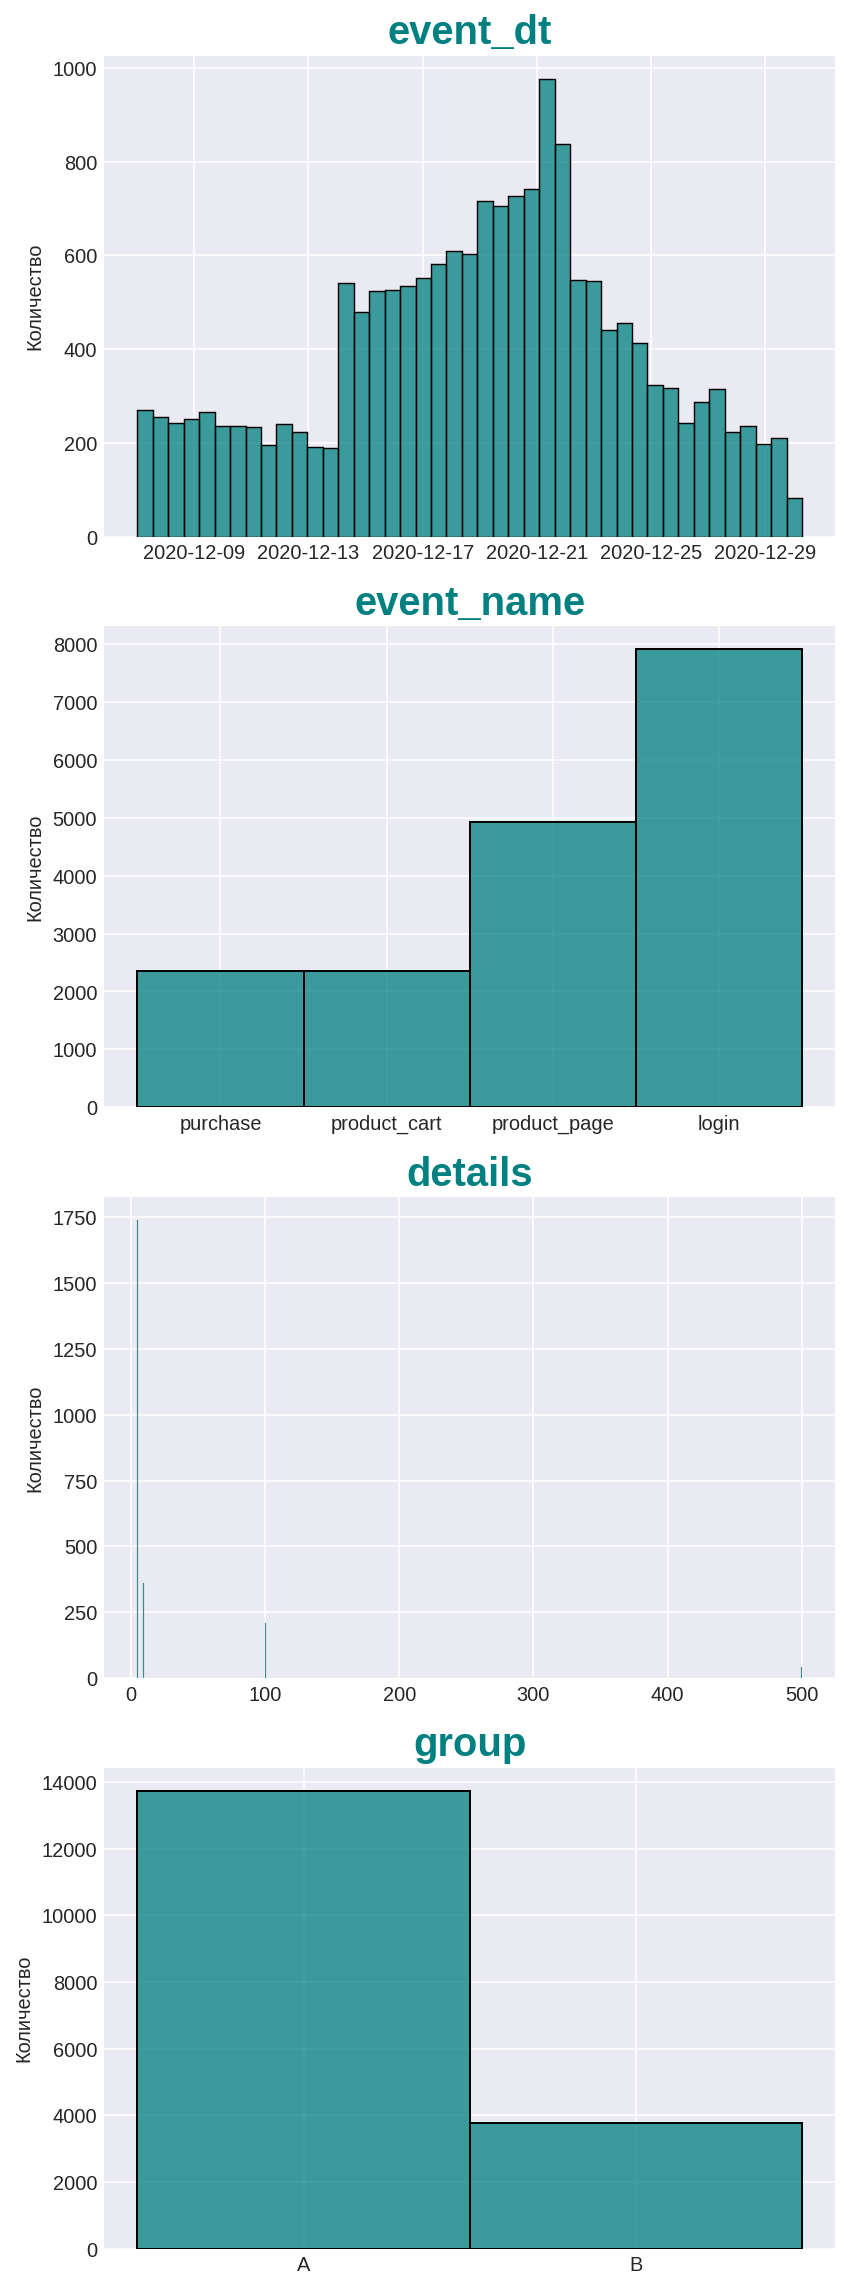

In [25]:
features = ['event_dt', 'event_name', 'details', 'group']
fig, axes = plt.subplots(len(features), 1, figsize=(6,16))
fig.set_tight_layout('pad')
for i, col in enumerate(features):
    axes[i].set_title(col, fontsize=20, fontweight='bold', color='teal')
    sns.histplot(x=col, data=relevant_table, ax=axes[i], color='teal')
    axes[i].set_xlabel(None)
    axes[i].set_ylabel('Количество')

1. До 14 декабря пользователи совершали примерно одинаковое количество действий в день, но затем вовлечённость начала резко расти. При этом после 21 декабря началось падение и возврат к обычной активности. Возможно, люди покупали подарки к Рождеству.
2. Чуть больше четверти заходов закончились покупкой — хороший результат.
3. Данные о стоимости покупки рассмотрим отдельно.
4. Действий в группе А существенно больше, чем в группе В — в 3.5 раза.

Посмотрим также на соотношение тестовой и контрольной групп.

In [26]:
groupsize = (
    participants
    .query('ab_test=="recommender_system_test" \
    and user_id in @participants_without_crossovers \
    and user_id in @relevant_new_users')
    .groupby('group').agg({'user_id': 'nunique'})
)
groupsize

,user_id
group,
A,2713
B,2036


Группа А больше группы В. Тест будет непараметрическим, поэтому дисбаланс не исказит результаты.

Посмотрим на распределение стоимости покупок.

In [27]:
relevant_table['details'].describe()

count    2348.000000
mean       22.643322
std        68.349804
min         4.990000
25%         4.990000
50%         4.990000
75%         9.990000
max       499.990000
Name: details, dtype: float64

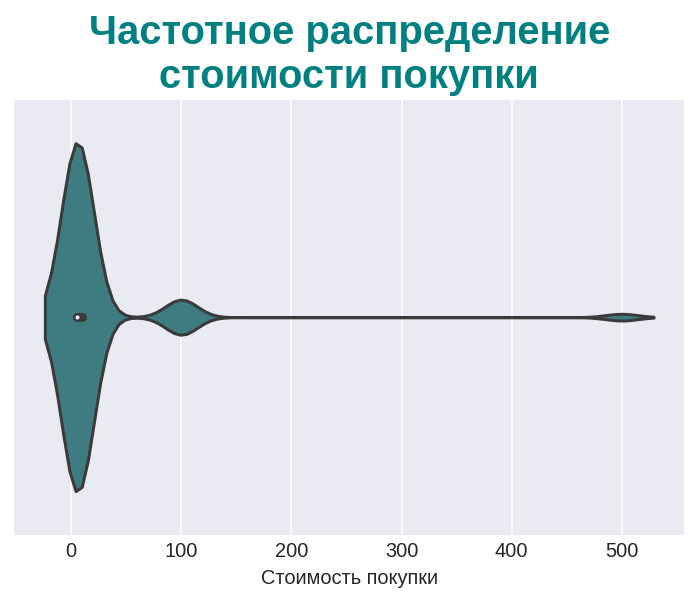

In [28]:
sns.violinplot(x='details', data=relevant_table, palette='crest')
plt.title('Частотное распределение\nстоимости покупки', fontsize=20, fontweight='bold', color='teal')
plt.xlabel('Стоимость покупки');

Больше половины заказов стоили 4.99 долларов. Дорогих заказов (99.99 и 499.99) очень мало, это скорее выбросы.

Посмотрим, отличается ли количество действий на пользователя между группами.

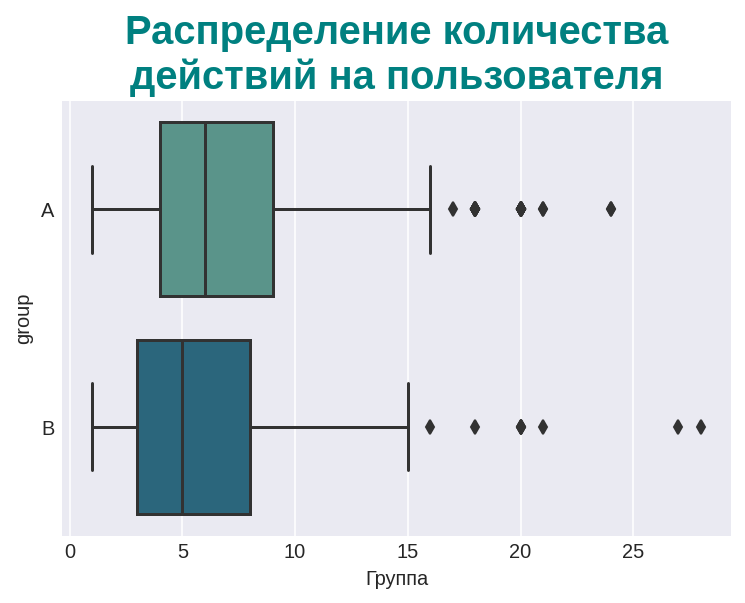

In [29]:
sns.boxplot(
    x='event_name',
    y='group',
    data=(
        relevant_table
        .groupby(['group', 'user_id'], as_index=False)
        ['event_name']
        .count()
    ),
    palette='crest'
)
plt.title('Распределение количества\nдействий на пользователя', fontsize=20, fontweight='bold', color='teal')
plt.xlabel('Количество действий')
plt.xlabel('Группа');

Медианное количество действий в группе А — 6, на 1 больше, чем в В. Возможно, эти различия получились случайно. В целом распределение выглядит похоже.

Посмотрим воронку действий пользователей. Для этого построим сводную таблицу.

In [30]:
funnel = (
    relevant_table
    .pivot_table(
        index='event_name',
        columns='group',
        values='user_id',
        aggfunc='nunique',
        sort=False)
    [::-1]
)

In [31]:
funnel

group,A,B
event_name,,
login,1939,655
product_page,1265,367
product_cart,589,184
purchase,613,191


Добавим исходные размеры групп.

In [32]:
a_groupsize = groupsize.loc['A', 'user_id']
b_groupsize = groupsize.loc['B', 'user_id']

In [33]:
funnel = pd.DataFrame([[a_groupsize, b_groupsize]], columns=list('AB'), index=['group_size']).append(funnel)

In [34]:
funnel

,A,B
group_size,2713,2036
login,1939,655
product_page,1265,367
product_cart,589,184
purchase,613,191


Совершали покупку больше пользователей, чем заходили в корзину. Возможно, это ошибка нашей фильтрации, проверим.

In [35]:
participants.query(
    'ab_test=="recommender_system_test" \
    and user_id in @participants_without_crossovers \
    and user_id in @relevant_new_users')\
    .groupby('group').agg({'user_id': 'nunique'})

,user_id
group,
A,2713
B,2036


In [36]:
events.groupby('event_name')['event_dt'].count().sort_values(ascending=False)

event_name
login           189552
product_page    125563
purchase         62740
product_cart     62462
Name: event_dt, dtype: int64

В изначальных данных то же самое. Значит, некоторые пользователи переходили со страницы товара сразу к оплате — через кнопку «Купить в 1 клик». Конверсию в покупку в таком случае будем считать не от корзины, а от страницы товара.

Посчитаем конверсию для групп А и В.

In [37]:
groupsize_dict = {'A_groupsize': a_groupsize, 'B_groupsize': b_groupsize}
for col in ['A', 'B']:
    for i in funnel.index:
        funnel.loc[i, col+'_CR'] = round(funnel.loc[i, col] / groupsize_dict[col+'_groupsize'] * 100, 2)

Также посчитаем прирост конверсии в группе В по сравнению с группой А.

In [38]:
funnel['gain'] = round((funnel['B_CR'] / funnel['A_CR'] - 1) * 100, 2)

Посмотрим на получившуюся таблицу.

In [39]:
funnel

,A,B,A_CR,B_CR,gain
group_size,2713,2036,100.00,100.00,0.00
login,1939,655,71.47,32.17,-54.99
product_page,1265,367,46.63,18.03,-61.33
product_cart,589,184,21.71,9.04,-58.36
purchase,613,191,22.59,9.38,-58.48


У группы В все показатели упали более чем в 2 раза по сравнению с группой А. В первую очередь из-за того, что больше 2/3 пользователей из группы В по какой-то причине вообще не заходили на сайт после регистрации. Что-то явно пошло не так.

<a class="anchor" id="21-bullet">

## Проверяем результаты А/В-теста

Для удобства напишем функцию, которая будет принимать метрики для сравнения, а возвращать р-уровень значимости и вывод о принятии или отвержении нулевой гипотезы.

In [40]:
def ztest_2samp(event):
    '''Возвращает p-value для выбранной пропорции.
    
    Параметры:
    data (DataFrame) — датасет, из которого извлекаются выборки.
    event_1 (str) — название первого события для сравнения.
    event_2 (str) — название первого события для сравнения.
    '''
    pvalue = proportions_ztest(
        [funnel.loc[event, 'A'],
         funnel.loc[event, 'B']],
        [funnel.loc['group_size', 'A'],
         funnel.loc['group_size', 'B']])[1]
    alpha = .05
    if pvalue < alpha:
        conclusion = 'Отвергаем Ho'
    else:
        conclusion = 'Не получилось отвергнуть Ho'
    print(f'{event}: p-value = {pvalue} — {conclusion}')

Сформулируем нулевые гипотезы:

$H_0$: Конверсии в группах А и В не отличаются.  
$H_1$: Конверсии в группах А и В отличаются.

Проверим значимость различия конверсий перехода на страницу товара.

In [41]:
for i in funnel.index:
    if i != 'group_size':
        ztest_2samp(i)

login: p-value = 1.2365312205471603e-159 — Отвергаем Ho
product_page: p-value = 9.647273923449549e-94 — Отвергаем Ho
product_cart: p-value = 1.1608883037541786e-31 — Отвергаем Ho
purchase: p-value = 2.8985176522818965e-33 — Отвергаем Ho


Во всех тестах р-уровень значимости ожидаемо оказался сильно ниже критического значения. Конверсии в группах значимо различаются, и можно с уверенностью говорить о том, что в группе В все показатели конверсии в два раза ниже, чем в группе А.

## Вывод

1. Тест по времени пересекался с крупным маркетинговым событием — Рождеством и Новым годом.
2. 1602 пользователя участвовали в конкурирующих тестах.
3. Мы отобрали только тех, которые удовлетворяют техническому заданию.
4. Тест не удовлетворяет ТЗ — участников меньше, чем было заявлено, а также аудитория составляет 10% от новых пользователей из ЕС вместо 15%, требуемых по техническому заданию.
5. С 14 по 21 декабря был резкий рост количества действий пользователей. После — спад к обычным значениям.
6. Группа А больше группы В.
7. Больше половины заказов стоили 5 долларов.
8. Некоторые пользователи не заходят в корзину, а сразу оплачивают товар быстрым способом.
9. Около 2/3 пользователей из группы В после регистрации больше не заходили на сайт. Возможно, это ошибка теста, а возможно, что-то из изменений им не понравилось.
10. Из-за этого остальные метрики обвалились более чем в 2 раза.

Тест был проведён некорректно, возможно, из-за этого возникла такая большая разница в конверсии.  
Из последних двух пунктов можно сделать вывод, что **изменения рекомендательной системы ухудшили метрики продукта.**